In [1]:
import numpy as np
import matplotlib.pyplot as plt

ps = (2,3,5,10,20,50,100,200,500)        #different choices for matrix dimension
a = np.linspace(0.0, 2*np.pi, 100)
x_circ = np.sin(a)
y_circ = np.cos(a)

distribution of random matrices with normal entries

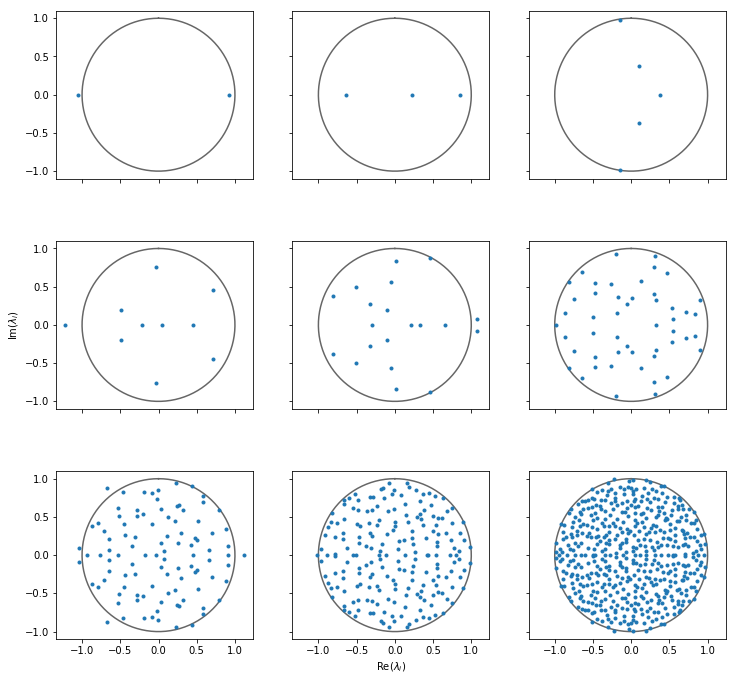

In [2]:
fig,axs = plt.subplots(3,3,subplot_kw={'aspect':1.0}, figsize=(12,12), sharex=True, sharey=True)
for p,ax in zip(ps,axs.flat):
    eig = np.linalg.eigvals(np.random.normal(size=(p,p)))
    ax.plot(x_circ, y_circ, color='0.4')
    ax.plot(eig.real/np.sqrt(p), eig.imag/np.sqrt(p), marker='.', ls='none')
axs[-1,1].set_xlabel('Re($\lambda_i$)')
axs[1,0].set_ylabel('Im($\lambda_i$)')
None

distribution of random matrices with uniform entries

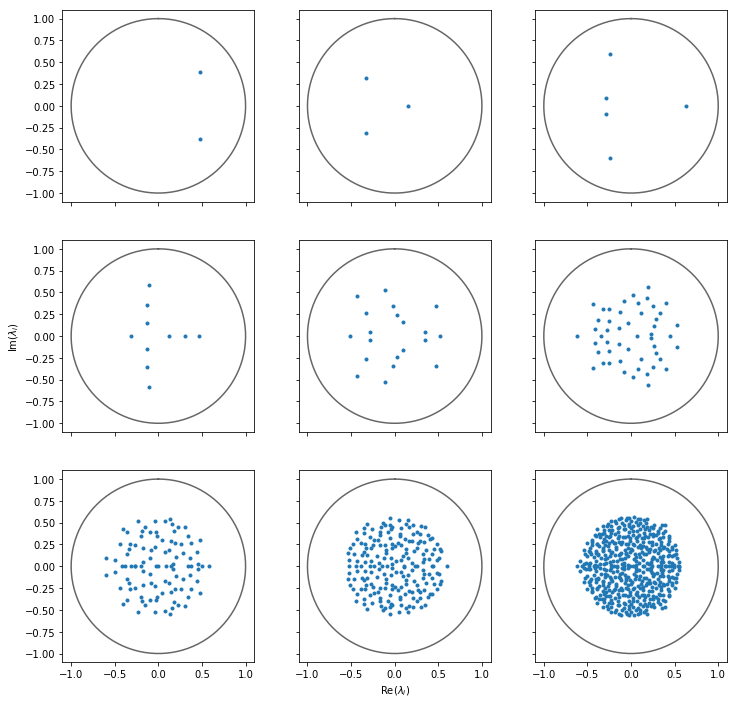

In [3]:
fig,axs = plt.subplots(3,3,subplot_kw={'aspect':1.0}, figsize=(12,12), sharex=True, sharey=True)
for p,ax in zip(ps,axs.flat):
    eig = np.linalg.eigvals(np.random.uniform(size=(p,p), low=-1.0, high=1.0))
    ax.plot(x_circ, y_circ, color='0.4')
    ax.plot(eig.real/np.sqrt(p), eig.imag/np.sqrt(p), marker='.', ls='none')
axs[-1,1].set_xlabel('Re($\lambda_i$)')
axs[1,0].set_ylabel('Im($\lambda_i$)')
None

histogram of distribution

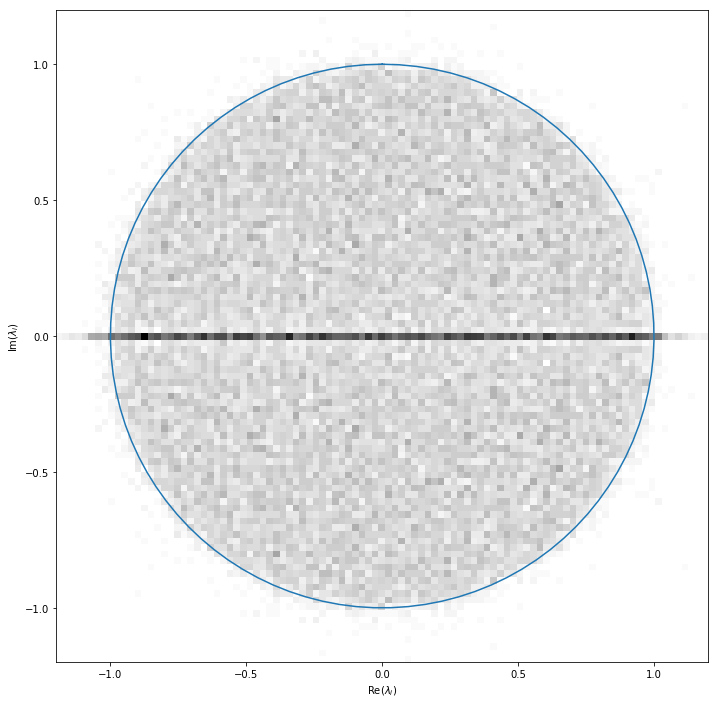

In [4]:
niter = 50
bin_edges = np.linspace(-1.2, 1.2, 100)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
hist = np.zeros((bin_edges.size-1,bin_edges.size-1))

for p in ps:
    sqrt_p = np.sqrt(p)
    for i in range(niter):
        eig = np.linalg.eigvals(np.random.normal(size=(p,p)))
        hist += np.histogram2d(x=eig.real/sqrt_p, y=eig.imag/sqrt_p, bins=(bin_edges,bin_edges))[0]

fig, ax = plt.subplots(subplot_kw={'aspect':1.0}, figsize=(12,12))
ax.pcolormesh(bin_edges, bin_edges, hist.T, cmap=plt.get_cmap('gray_r'))
ax.plot(x_circ, y_circ)
ax.set(xlabel='Re($\lambda_i$)', ylabel='Im($\lambda_i$)')
None

a look at the radius

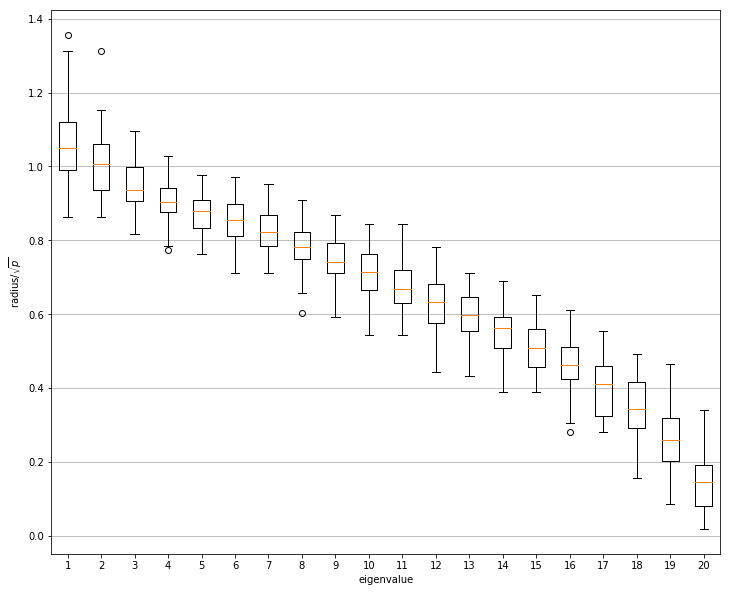

In [5]:
niter = 50
p = 20

rad = np.empty((niter,p))
for i in range(niter):
    eig = np.linalg.eigvals(np.random.normal(size=(p,p)))
    rad[i,:] = np.sqrt((eig.real)**2 + (eig.imag)**2)/np.sqrt(p)

rad.sort(axis=1)

fig, ax = plt.subplots(figsize=(12,10))
ax.boxplot(rad[:,::-1])
ax.yaxis.grid(True)
ax.set(xlabel='eigenvalue', ylabel='radius/$\sqrt{p}$')
None

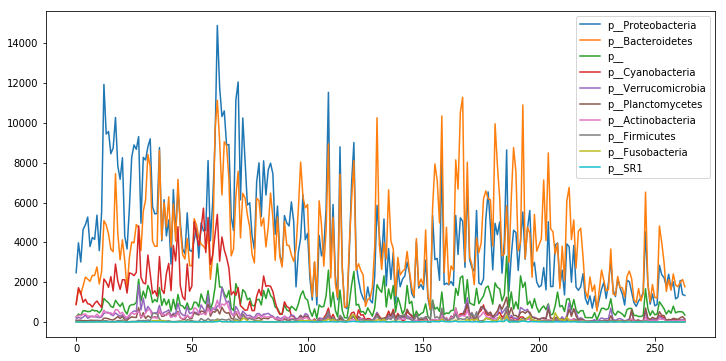

In [6]:
import pystan
import pandas

p = 10

DAT = pandas.read_csv('../../bayesian_cbiomes/case_studies/MV_AR1/data/bacterial_OTU.csv')

# Aggregate the data by phyla, which is indicated in the third column ("phylum") of the dataset:
phyla = np.unique(DAT['phylum']) # extract unique phyla IDs

# sum all OTUs of that phylum
# use sums as rows for new DataFrame
PHY = pandas.DataFrame([DAT.loc[DAT['phylum']==phylum].iloc[:,8:].sum() for phylum in phyla])
# associate each row with phylum
PHY = PHY.set_index(phyla)
PHY.sum(axis=1)

index_maxp = np.argsort(PHY.sum(axis=1).values)[-p:][::-1]

PHY = PHY.iloc[index_maxp]

fig,ax = plt.subplots(figsize=(12,6))
ax.plot(PHY.values.T)
ax.legend(PHY.index)
None

In [7]:
mod_code = '''data {
    int T;         //length of time series
    int p;         //number of variables
    matrix[p,T] Y; //matrix of observations; variables are rows; time is columns
    real phi_mu;   //PHI prior distribution parameter
    real phi_sigma; //PHI prior distribution parameter
}
parameters{
    matrix[p,p] PHI;     //dynamics matrix
    vector<lower=1E-15>[p] sigma;     //variances of stochastic forcing
    vector[p] init;      //mean of initial conditions as parameter vector
}
model{
    for (icol in 1:p){
        PHI[,icol] ~ normal(phi_mu,phi_sigma);
    }
    Y[,1] ~ normal(init, sigma);            //distribution of the initial conditions
    for(i in 2:T){
        Y[,i] ~ normal(PHI*Y[,i-1],sigma);  //conditional predictive distribution
    }
}
'''
mod = pystan.StanModel(model_code=mod_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dd1ea11859c7683002ab7f53f1a0b8e4 NOW.


In [8]:
phi_mu = 0.0
phi_sigma = 1.0

dat_PHY = {'T':PHY.shape[1], 'p':PHY.shape[0], 'Y':PHY.values, 'phi_mu':phi_mu, 'phi_sigma':phi_sigma}
mcmc = mod.sampling(data=dat_PHY, iter=2000, warmup=1000)
print(mcmc)

Inference for Stan model: anon_model_dd1ea11859c7683002ab7f53f1a0b8e4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
PHI[1,1]     0.76  1.5e-3   0.09   0.57    0.7   0.76   0.82   0.94   3941    1.0
PHI[2,1]     0.03  1.6e-3    0.1  -0.16  -0.03   0.03    0.1   0.23   3861    1.0
PHI[3,1]   2.3e-3  5.0e-4   0.03  -0.05  -0.02 2.3e-3   0.02   0.05   2989    1.0
PHI[4,1]     0.06  5.7e-4   0.03-5.2e-3   0.03   0.06   0.08   0.11   2883    1.0
PHI[5,1]   2.9e-3  2.0e-4   0.01  -0.02-5.0e-3 3.0e-3   0.01   0.03   3568    1.0
PHI[6,1]    -0.01  1.6e-4 9.7e-3  -0.03  -0.02  -0.01-4.2e-3 8.3e-3   3560    1.0
PHI[7,1]   7.4e-3  1.1e-4 6.5e-3-5.5e-3 3.2e-3 7.3e-3   0.01   0.02   3273    1.0
PHI[8,1]  -3.0e-3  1.1e-4 6.5e-3  -0.02-7.2e-3-3.0e-3 1.3e-3 9.6e-3   3578    1.0
PHI[9,1]  -1.6e-3  4.8e-5 3.1e-3-7.6e-3-3.7e-3-1.6e-3 4.6e-4 4.3e-3   415

In [9]:
niter = 2000
bin_edges = np.linspace(-1.2, 1.2, 100)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
hist_prior = np.zeros((bin_edges.size-1,bin_edges.size-1))
hist_posterior = np.zeros((bin_edges.size-1,bin_edges.size-1))

sqrt_p = np.sqrt(p)
for i in range(niter):
    eig = np.linalg.eigvals(np.random.normal(size=(p,p), loc=phi_mu, scale=phi_sigma))
    hist_prior += np.histogram2d(x=eig.real/sqrt_p, y=eig.imag/sqrt_p, bins=(bin_edges,bin_edges))[0]

for i in range(mcmc['PHI'].shape[0]):
    eig = np.linalg.eigvals(mcmc['PHI'][i,:,:])
    hist_posterior += np.histogram2d(x=eig.real/sqrt_p, y=eig.imag/sqrt_p, bins=(bin_edges,bin_edges))[0]


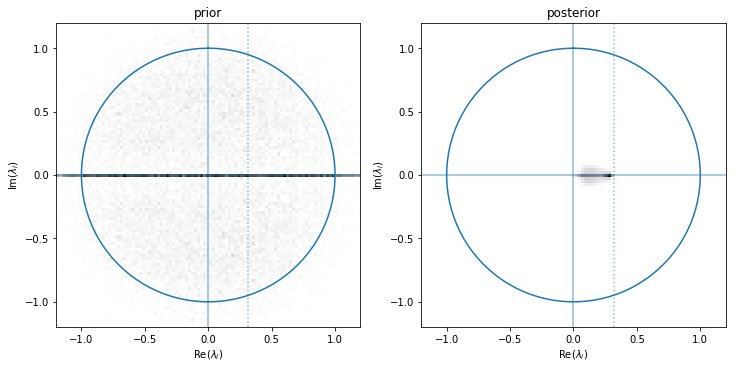

In [10]:
fig, axs = plt.subplots(ncols=2, subplot_kw={'aspect':1.0}, figsize=(12,6))
axs[0].pcolormesh(bin_edges, bin_edges, hist_prior.T, cmap=plt.get_cmap('gray_r'))
axs[1].pcolormesh(bin_edges, bin_edges, hist_posterior.T, cmap=plt.get_cmap('gray_r'))
for ax in axs.flat:
    ax.plot(x_circ, y_circ)
    ax.axvline(0.0, color='C0', alpha=0.5)
    ax.axvline(1.0/np.sqrt(p), color='C0', alpha=0.5, ls=':')
    ax.axhline(0.0, color='C0', alpha=0.5)
    ax.set(xlabel='Re($\lambda_i$)', ylabel='Im($\lambda_i$)')
ax
axs[0].set_title('prior')
axs[1].set_title('posterior')
None

### try again with genus

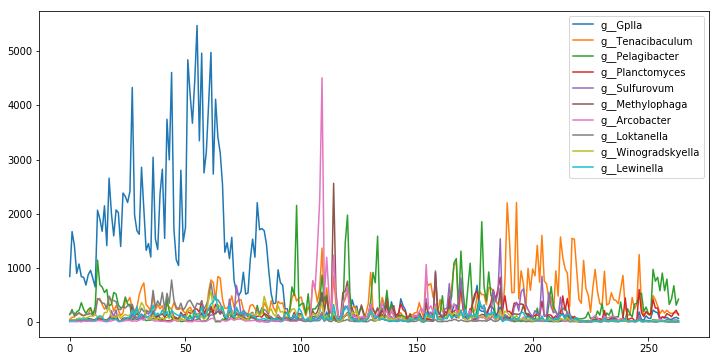

In [11]:
# Aggregate the data by genus, which is indicated in the column "genus" of the dataset:
genera = np.unique(DAT['genus']) # extract unique genera IDs

# remove catch-all "g__" genus
genera = genera[genera!='g__']

# sum all OTUs of that phylum
# use sums as rows for new DataFrame
gen = pandas.DataFrame([DAT.loc[DAT['genus']==genus].iloc[:,8:].sum() for genus in genera])
# associate each row with phylum
gen = gen.set_index(genera)
gen.sum(axis=1)

index_maxp = np.argsort(gen.sum(axis=1).values)[-p:][::-1]

gen = gen.iloc[index_maxp]

fig,ax = plt.subplots(figsize=(12,6))
ax.plot(gen.values.T)
ax.legend(gen.index)
None

In [12]:
phi_mu = 0.0
phi_sigma = 1.0

dat_gen = {'T':gen.shape[1], 'p':gen.shape[0], 'Y':gen.values, 'phi_mu':phi_mu, 'phi_sigma':phi_sigma}
mcmc_gen = mod.sampling(data=dat_gen, iter=2000, warmup=1000)
print(mcmc_gen)

Inference for Stan model: anon_model_dd1ea11859c7683002ab7f53f1a0b8e4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
PHI[1,1]     0.88  1.1e-3   0.07   0.74   0.83   0.88   0.93   1.02   4200    1.0
PHI[2,1]    -0.03  6.9e-4   0.04  -0.12  -0.06  -0.03-1.6e-3   0.06   3924    1.0
PHI[3,1]    -0.06  6.7e-4   0.04  -0.14  -0.09  -0.06  -0.04   0.01   3575    1.0
PHI[4,1]     0.01  2.5e-4   0.02  -0.02 4.0e-3   0.01   0.03   0.04   4253    1.0
PHI[5,1]  -9.9e-3  3.6e-4   0.02  -0.05  -0.02-9.8e-3 5.3e-3   0.03   3896    1.0
PHI[6,1]   5.9e-3  4.3e-4   0.03  -0.05  -0.01 6.3e-3   0.02   0.06   3833    1.0
PHI[7,1]  -6.8e-3  6.2e-4   0.04  -0.08  -0.03-6.8e-3   0.02   0.07   3987    1.0
PHI[8,1]     0.03  1.5e-4   0.01   0.01   0.03   0.03   0.04   0.05   4448    1.0
PHI[9,1]     0.01  1.5e-4 9.5e-3-4.4e-3 7.2e-3   0.01   0.02   0.03   389

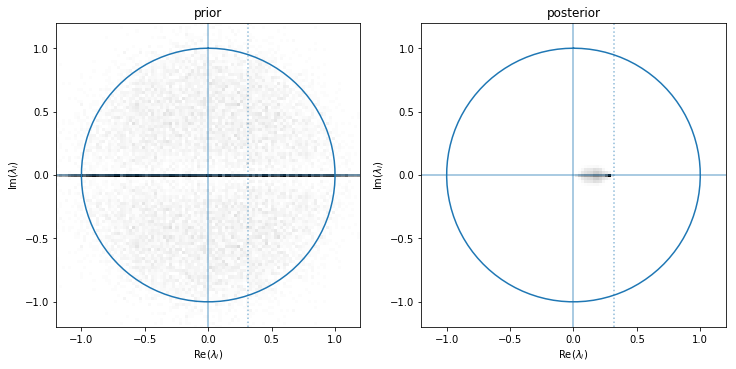

In [13]:
niter = 2000
bin_edges = np.linspace(-1.2, 1.2, 100)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
hist_gen_prior = np.zeros((bin_edges.size-1,bin_edges.size-1))
hist_gen_posterior = np.zeros((bin_edges.size-1,bin_edges.size-1))

sqrt_p = np.sqrt(p)
for i in range(niter):
    eig = np.linalg.eigvals(np.random.normal(size=(p,p), loc=phi_mu, scale=phi_sigma))
    hist_gen_prior += np.histogram2d(x=eig.real/sqrt_p, y=eig.imag/sqrt_p, bins=(bin_edges,bin_edges))[0]

for i in range(mcmc_gen['PHI'].shape[0]):
    eig = np.linalg.eigvals(mcmc_gen['PHI'][i,:,:])
    hist_gen_posterior += np.histogram2d(x=eig.real/sqrt_p, y=eig.imag/sqrt_p, bins=(bin_edges,bin_edges))[0]

fig, axs = plt.subplots(ncols=2, subplot_kw={'aspect':1.0}, figsize=(12,6))
axs[0].pcolormesh(bin_edges, bin_edges, hist_gen_prior.T, cmap=plt.get_cmap('gray_r'))
axs[1].pcolormesh(bin_edges, bin_edges, hist_gen_posterior.T, cmap=plt.get_cmap('gray_r'))
for ax in axs.flat:
    ax.plot(x_circ, y_circ)
    ax.axvline(0.0, color='C0', alpha=0.5)
    ax.axvline(1.0/np.sqrt(p), color='C0', alpha=0.5, ls=':')
    ax.axhline(0.0, color='C0', alpha=0.5)
    ax.set(xlabel='Re($\lambda_i$)', ylabel='Im($\lambda_i$)')
axs[0].set_title('prior')
axs[1].set_title('posterior')
None

### compare phylum and genus posterior

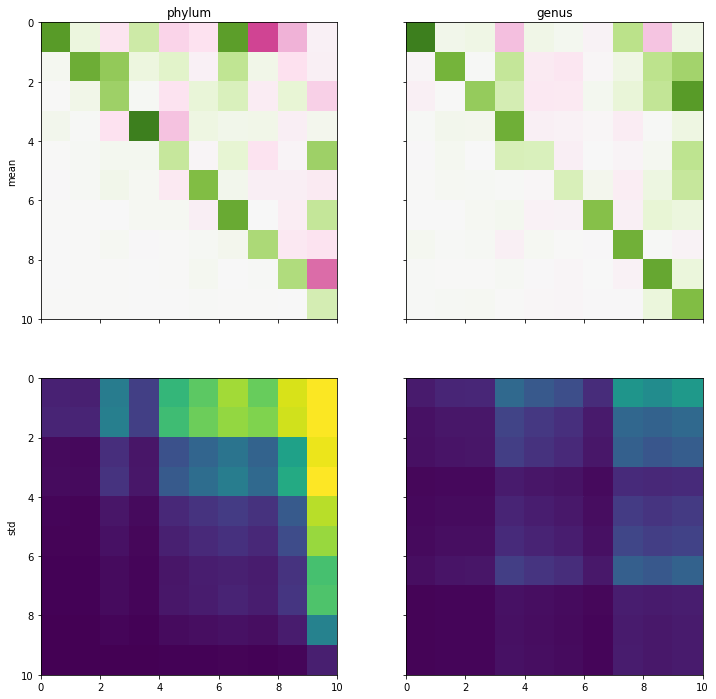

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=2, subplot_kw={'aspect':1.0}, figsize=(12,12), sharex=True, sharey=True)
axs[0,0].pcolormesh(np.mean(mcmc['PHI'], axis=0), cmap=plt.get_cmap('PiYG'), norm=mpl.colors.Normalize(vmin=-1,vmax=1))
axs[1,0].pcolormesh(np.std(mcmc['PHI'], axis=0), norm=mpl.colors.Normalize(vmin=0,vmax=1))
axs[0,1].pcolormesh(np.mean(mcmc_gen['PHI'], axis=0), cmap=plt.get_cmap('PiYG'), norm=mpl.colors.Normalize(vmin=-1,vmax=1))
axs[1,1].pcolormesh(np.std(mcmc_gen['PHI'], axis=0), norm=mpl.colors.Normalize(vmin=0,vmax=1))

axs[0,0].set(title='phylum', ylabel='mean')
axs[1,0].set_ylabel('std')
axs[0,1].set_title('genus')

axs[0,0].invert_yaxis()

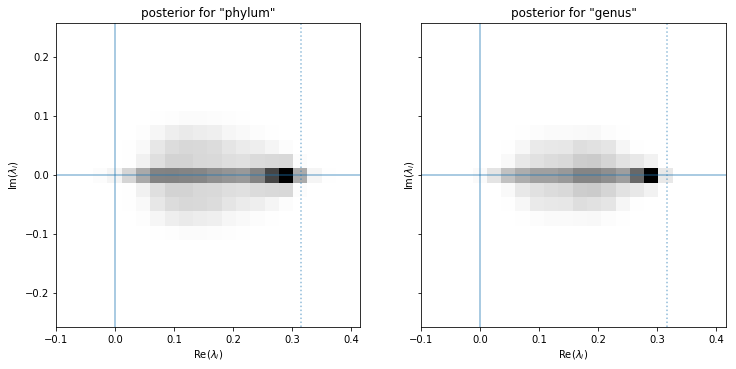

In [15]:
fig, axs = plt.subplots(ncols=2, subplot_kw={'aspect':1.0}, figsize=(12,6), sharex=True, sharey=True)
axs[0].pcolormesh(bin_edges, bin_edges, hist_posterior.T, cmap=plt.get_cmap('gray_r'))
axs[1].pcolormesh(bin_edges, bin_edges, hist_gen_posterior.T, cmap=plt.get_cmap('gray_r'))
for ax in axs.flat:
    ax.plot(x_circ, y_circ)
    ax.axvline(0.0, color='C0', alpha=0.5)
    ax.axvline(1.0/np.sqrt(p), color='C0', alpha=0.5, ls=':')
    ax.axhline(0.0, color='C0', alpha=0.5)
    ax.set(xlabel='Re($\lambda_i$)', ylabel='Im($\lambda_i$)')
axs[0].set_title('posterior for "phylum"')
axs[1].set_title('posterior for "genus"')

axs[0].set(xlim=(-0.1,1/np.sqrt(p)+0.1), ylim=(-0.5/np.sqrt(p)-0.1, 0.5/np.sqrt(p)+0.1))
None

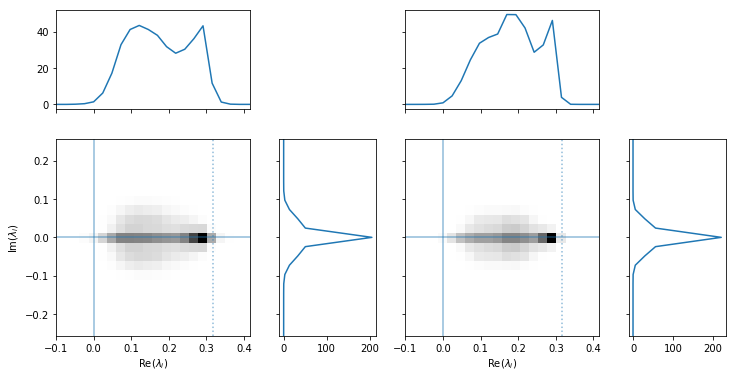

In [16]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12,6), sharex='col', sharey='row', gridspec_kw={'height_ratios':(1,2), 'width_ratios':(2,1,2,1)})
axs[1,0].pcolormesh(bin_edges, bin_edges, hist_posterior.T, cmap=plt.get_cmap('gray_r'))
axs[1,2].pcolormesh(bin_edges, bin_edges, hist_gen_posterior.T, cmap=plt.get_cmap('gray_r'))

axs[0,0].plot(bin_centers, np.mean(hist_posterior,axis=1))
axs[1,1].plot(np.mean(hist_posterior,axis=0),bin_centers)

axs[0,2].plot(bin_centers, np.mean(hist_gen_posterior,axis=1))
axs[1,3].plot(np.mean(hist_gen_posterior,axis=0),bin_centers)

axs[1,0].set(xlabel='Re($\lambda_i$)', ylabel='Im($\lambda_i$)')
axs[1,2].set(xlabel='Re($\lambda_i$)')

for ax in axs[1,0::2]:
    ax.plot(x_circ, y_circ)
    ax.axvline(0.0, color='C0', alpha=0.5)
    ax.axvline(1.0/np.sqrt(p), color='C0', alpha=0.5, ls=':')
    ax.axhline(0.0, color='C0', alpha=0.5)
    ax.set(xlim=(-0.1,1/np.sqrt(p)+0.1), ylim=(-0.5/np.sqrt(p)-0.1, 0.5/np.sqrt(p)+0.1))
    
for ax in axs[0,1::2]:
    ax.set_visible(False)

### examine the leading eigenvalues (largest real part)

In [17]:
leadeig = {}

def get_leadeig(matrix):
    eig = np.linalg.eigvals(matrix)
    #eig.sort(key=lambda x: x.real)
    return np.sort_complex(eig)[-1]

leadeig['prior'] = np.full((niter,2), fill_value=np.nan)
for i in range(niter):
    eig = get_leadeig(np.random.normal(size=(p,p), loc=phi_mu, scale=phi_sigma))
    leadeig['prior'][i,0] = eig.real
    leadeig['prior'][i,1] = eig.imag

leadeig['phylum'] = np.full((mcmc['PHI'].shape[0],2), fill_value=np.nan)
for i in range(mcmc['PHI'].shape[0]):
    eig = get_leadeig(mcmc['PHI'][i,:,:])
    leadeig['phylum'][i,0] = eig.real
    leadeig['phylum'][i,1] = eig.imag
    
leadeig['genus'] = np.full((mcmc_gen['PHI'].shape[0],2), fill_value=np.nan)
for i in range(mcmc_gen['PHI'].shape[0]):
    eig = get_leadeig(mcmc_gen['PHI'][i,:,:])
    leadeig['genus'][i,0] = eig.real
    leadeig['genus'][i,1] = eig.imag

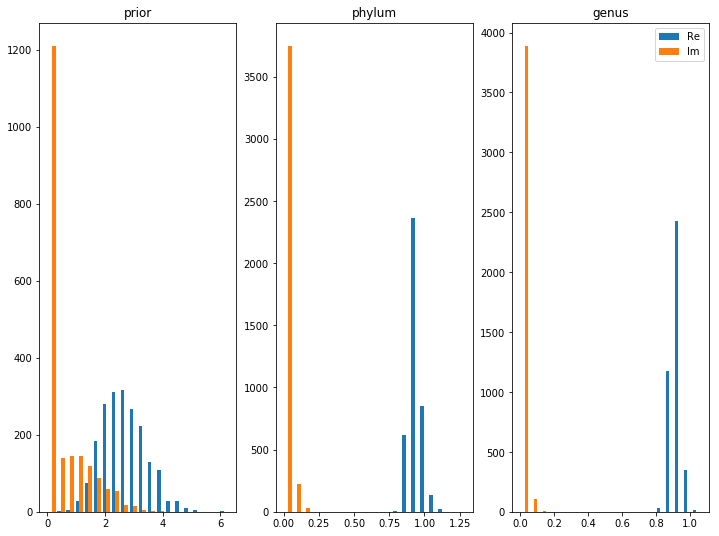

In [18]:
fig, axs = plt.subplots(ncols=len(leadeig), figsize=(12,9))
for ax,name in zip(axs,leadeig):
    ax.hist(leadeig[name], bins=20)
    ax.set_title(name)
ax.legend(('Re','Im'))

qq-plot

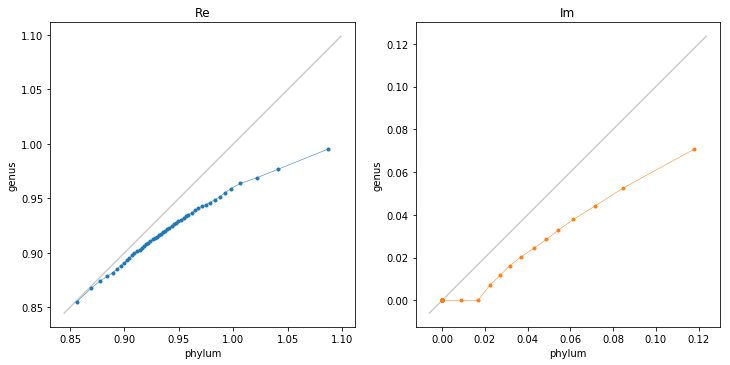

In [19]:
q_real = {k:np.percentile(leadeig[k][:,0], q=np.arange(1,100,2)) for k in ('phylum','genus')}
q_imag = {k:np.percentile(leadeig[k][:,1], q=np.arange(1,100,2)) for k in ('phylum','genus')}

fig, axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].plot(q_real['phylum'], q_real['genus'], marker='.', lw=0.5)
axs[1].plot(q_imag['phylum'], q_imag['genus'], marker='.', lw=0.5, color='C1')
for ax,reim in zip(axs,('Re','Im')):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    lim = (min(xlim[0],ylim[0]), max(xlim[1],ylim[1]))
    ax.plot(lim,lim,color='0.8', zorder=0)
    ax.set(aspect=1.0, xlabel='phylum', ylabel='genus', title=reim)

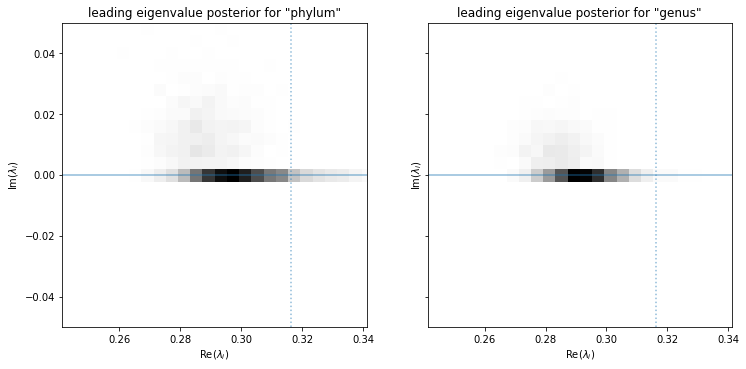

In [26]:
bin_edges_fine = np.linspace(-0.4, 0.4, 200)
bin_centers_fine = 0.5*(bin_edges_fine[1:]+bin_edges_fine[:-1])
hist_leading = {k:np.histogram2d(x=leadeig[k][:,0]/sqrt_p, y=leadeig[k][:,1]/sqrt_p, bins=(bin_edges_fine,bin_edges_fine))[0] for k in ('phylum','genus')}

fig, axs = plt.subplots(ncols=2, subplot_kw={'aspect':1.0}, figsize=(12,6), sharex=True, sharey=True)
for ax,k in zip(axs,hist_leading):
    ax.pcolormesh(bin_edges_fine, bin_edges_fine, hist_leading[k].T, cmap=plt.get_cmap('gray_r'))
for ax in axs.flat:
    ax.plot(x_circ, y_circ)
    ax.axvline(0.0, color='C0', alpha=0.5)
    ax.axvline(1.0/np.sqrt(p), color='C0', alpha=0.5, ls=':')
    ax.axhline(0.0, color='C0', alpha=0.5)
    ax.set(xlabel='Re($\lambda_i$)', ylabel='Im($\lambda_i$)')
axs[0].set_title('leading eigenvalue posterior for "phylum"')
axs[1].set_title('leading eigenvalue posterior for "genus"')

r = 0.05
axs[0].set(xlim=(1/np.sqrt(p)-1.5*r,1/np.sqrt(p)+0.5*r), ylim=(-r, r))
None

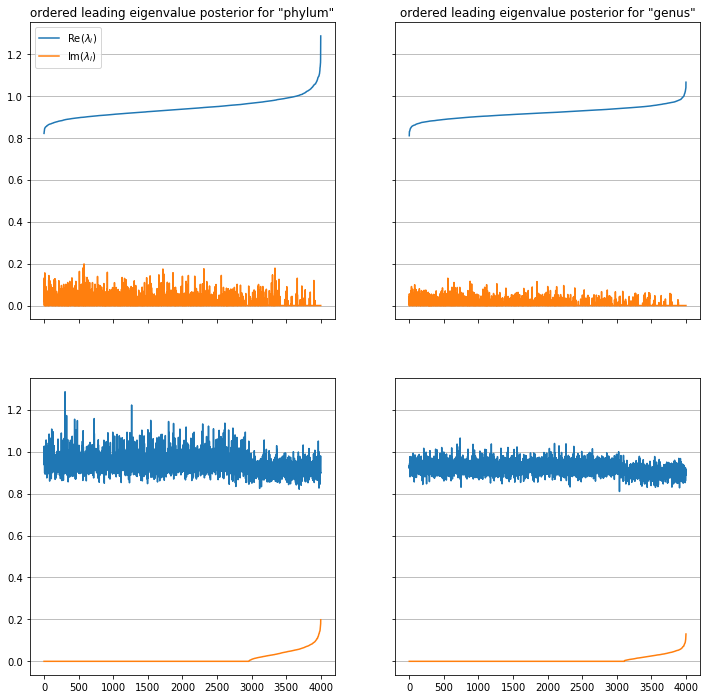

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,12), sharex=True, sharey=True)
for ax,k in zip(axs[0,:],('phylum','genus')):
    index = np.argsort(leadeig[k][:,0])
    ax.plot(leadeig[k][index,0], label='Re($\lambda_i$)')
    ax.plot(leadeig[k][index,1], label='Im($\lambda_i$)')
for ax,k in zip(axs[1,:],('phylum','genus')):
    index = np.argsort(leadeig[k][:,1])
    ax.plot(leadeig[k][index,0], label='Re($\lambda_i$)')
    ax.plot(leadeig[k][index,1], label='Im($\lambda_i$)')
for ax in axs.flat:
    ax.yaxis.grid(True)
axs[0,0].set_title('ordered leading eigenvalue posterior for "phylum"')
axs[0,1].set_title('ordered leading eigenvalue posterior for "genus"')    
axs[0,0].legend()

phylum sum index: 2961/4000
genus sum index: 3110/4000


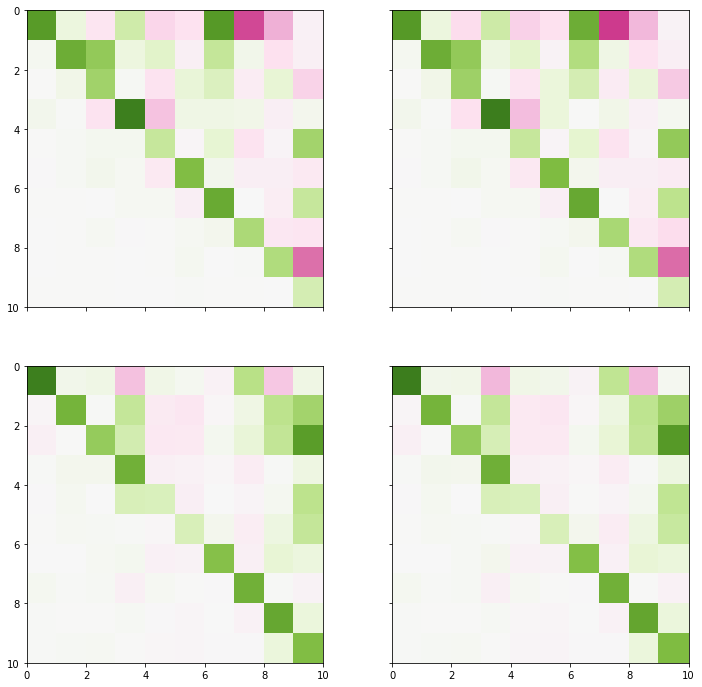

In [28]:
fig, axs = plt.subplots(ncols=2, nrows=2, subplot_kw={'aspect':1.0}, figsize=(12,12), sharex=True, sharey=True)

for axrow,k in zip(axs,('phylum','genus')):
    if k == 'phylum':
        cmcmc = mcmc
    else:
        cmcmc = mcmc_gen
    index = leadeig[k][:,1] < 1e-6
    print('{} sum index: {}/{}'.format(k, sum(index), index.size))

    axrow[0].pcolormesh(np.mean(cmcmc['PHI'][index,:,:], axis=0), cmap=plt.get_cmap('PiYG'), norm=mpl.colors.Normalize(vmin=-1,vmax=1))
    axrow[1].pcolormesh(np.mean(cmcmc['PHI'][np.logical_not(index),:,:], axis=0), cmap=plt.get_cmap('PiYG'), norm=mpl.colors.Normalize(vmin=-1,vmax=1))
axs[0,0].invert_yaxis()

None